<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Data exploration</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Data exploration, analysis

In [75]:
import _mypath
import os
import shap
import pandas as pd
import re
import fasttext
import spacy 
from sklearn.model_selection import train_test_split
from functools import partial
import csv
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import randint

import nltk
nltk.data.path.append("/data/DATALAB_PAU/18_HPC/nltk_data")

from nltk.corpus import stopwords

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_FOLDER = "/data/DATALAB_PAU/20_projects/j0215602/DS_NLP/input/data"

# Data loading

In [3]:
infile = os.path.join("../input/data/cleaned_merged_dataset.csv")
df = pd.read_csv(infile, sep=",", encoding="utf-8", engine="python")
print("data shape:", df.shape, end="\n\n")

df.head()

data shape: (105568, 8)



,Commentaire,star,date,client,reponse,source,company,langage
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr


# Data prep

## Cleaning (digits, max length 20, stops words, punctuations, lower case...)

In [4]:
nlp = spacy.load("fr_core_news_lg")

In [5]:
def cleanReview(text):
    pattern_email = re.compile(r"[a-zA-Z0-9.-]+@[a-zA-Z.]+")
    pattern_url1 = re.compile(r"https?://[a-zA-Z0-9./]+")
    pattern_url2 = re.compile(r"www\.[a-zA-Z0-9.-:/]+")

    text = pattern_email.sub(" ", text)
    text = pattern_url1.sub(" ", text)
    text = pattern_url2.sub(" ", text)
    text = re.sub(r' {2,}', " ", text)
    return text

def preprocess(token):
    if token.text.isnumeric(): return ""
    if len(token.text)<2 or len(token.text)>20: return ""
    if token.is_stop: return ""
    if token.ent_type_ == "PUNCT": return ""
    return token.lemma_

In [8]:
liste_transform = []
gen = nlp.pipe(df.Commentaire.str.lower().map(cleanReview), disable=["tagger", "parser", "attribute_ruler", "textcat"], n_process=5, batch_size=100)

for doc in tqdm(gen) : 
    text_preprocess = " ".join(preprocess(token) for token in doc)
    liste_transform.append(text_preprocess)

df['text_preprocess'] = liste_transform
df.head()

105568it [01:26, 1218.30it/s]


,Commentaire,star,date,client,reponse,source,company,langage,text_preprocess
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr,colis commander mardi fevrier livraison je...
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr,amazon politique pire contrairement ...
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr,dieu connaître déboire site marchand a...
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr,prelev commande jamais recevoir servi...
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr,colis dire livrer jamais recevoir perdre no...


In [17]:
df["star"].value_counts().sort_index()

star
1    24141
2     3607
3     6360
4    18427
5    53033
Name: count, dtype: int64

In [39]:
mapping = {1:0, 2:0, 
           3:1, 
           4:2, 5:2}

df["Sentiment"] = df["star"].replace(mapping).astype(int)
df.head()

,Commentaire,star,date,client,reponse,source,company,langage,text_preprocess,Sentiment
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr,colis commander mardi fevrier livraison je...,0
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr,amazon politique pire contrairement ...,0
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr,dieu connaître déboire site marchand a...,2
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr,prelev commande jamais recevoir servi...,0
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr,colis dire livrer jamais recevoir perdre no...,0


In [40]:
outfile = os.path.join(DATA_FOLDER, "bow_processed_dataset.csv")
df.to_csv(outfile, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

## DATASET SPLIT
### Binary classes

In [3]:
outfile = os.path.join(DATA_FOLDER, "bow_processed_dataset.csv")
df = pd.read_csv(outfile, sep=",", encoding="utf-8", engine="python")

In [41]:
df["Sentiment"].unique()

array([0, 2, 1])

In [46]:
df_train_bin = pd.DataFrame()
df_test_bin = pd.DataFrame()

for sentiment in [0,2]:
    mask = (df["Sentiment"]==sentiment)
    tmp = df.loc[mask].sample(frac=1)
    split_test_index = int(tmp.shape[0] * 0.8)
    df_train_bin = pd.concat((df_train_bin, tmp.iloc[:split_test_index]))
    df_test_bin = pd.concat((df_test_bin, tmp.iloc[split_test_index:]))

print("train set:", df_train_bin.shape)
print("test set:", df_test_bin.shape)

train set: (79366, 10)
test set: (19842, 10)


In [47]:
outfile_2cls_train = os.path.join(DATA_FOLDER, "bow_2cls_train.txt")
df_train_bin[["Sentiment", "text_preprocess"]].to_csv(outfile_2cls_train, sep=" ", encoding="utf-8")

outfile_2cls_test = os.path.join(DATA_FOLDER, "bow_2cls_test.txt")
df_test_bin[["Sentiment", "text_preprocess"]].to_csv(outfile_2cls_test, sep=" ", encoding="utf-8")

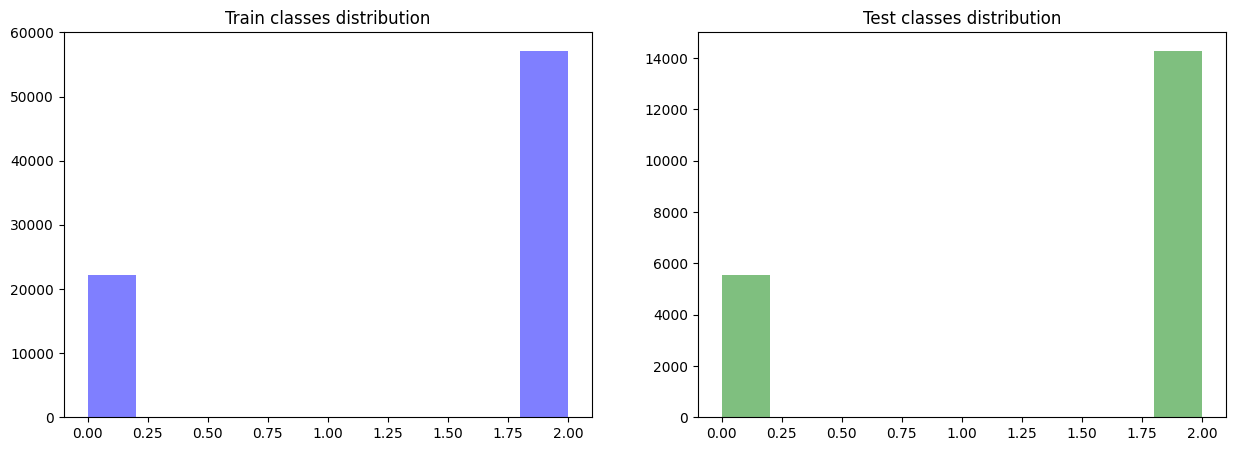

In [48]:
# Création du subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot de la distribution des classes dans le jeu de train
axs[0].hist(df_train_bin["Sentiment"], color='blue', alpha=0.5)
axs[0].set_title('Train classes distribution')

# Plot de la distribution des classes dans le jeu de test
axs[1].hist(df_test_bin["Sentiment"], color='green', alpha=0.5,)
axs[1].set_title('Test classes distribution')

# Affichage du subplot
plt.show()

### 3 Classes

In [24]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for sentiment in df["Sentiment"].unique():
    mask = (df["Sentiment"]==sentiment)
    tmp = df.loc[mask].sample(frac=1)
    split_test_index = int(tmp.shape[0] * 0.8)
    df_train = pd.concat((df_train, tmp.iloc[:split_test_index]))
    df_test = pd.concat((df_test, tmp.iloc[split_test_index:]))

print("train set:", df_train.shape)
print("test set:", df_test.shape)

train set: (67562, 10)
val set: (16892, 10)
test set: (21114, 10)


In [27]:
outfile_train = os.path.join(DATA_FOLDER, "bow_3cls_train.txt")
df_train[["Sentiment", "text_preprocess"]].to_csv(outfile_train, sep=" ", encoding="utf-8")

outfile_test = os.path.join(DATA_FOLDER, "bow_3cls_test.txt")
df_test[["Sentiment", "text_preprocess"]].to_csv(outfile_test, sep=" ", encoding="utf-8")

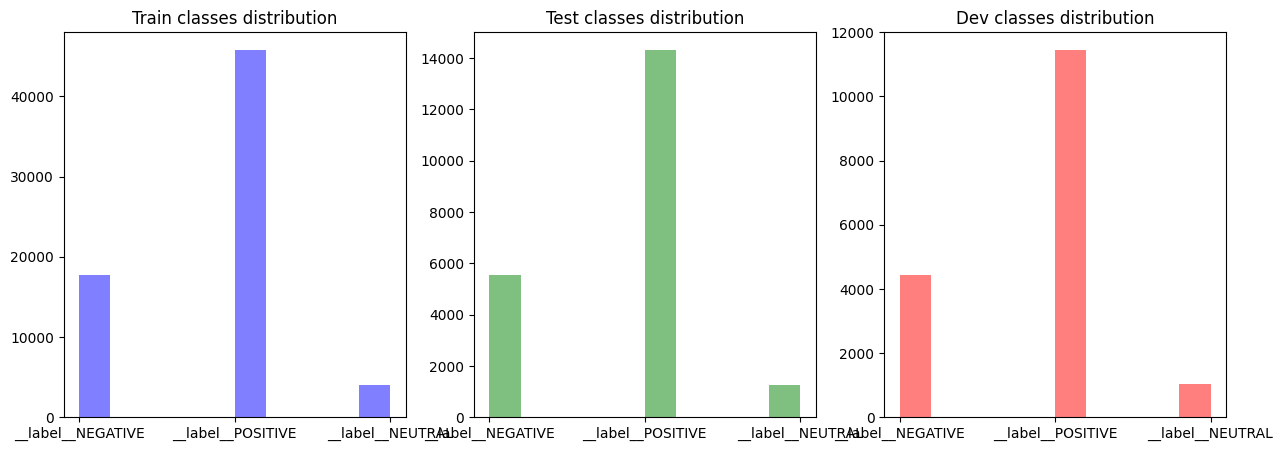

In [28]:
# Création du subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot de la distribution des classes dans le jeu de train
axs[0].hist(df_train["Sentiment"], color='blue', alpha=0.5)
axs[0].set_title('Train classes distribution')

# Plot de la distribution des classes dans le jeu de test
axs[1].hist(df_test["Sentiment"], color='green', alpha=0.5,)
axs[1].set_title('Test classes distribution')

# Affichage du subplot
plt.show()

Text(0.5, 1.0, 'Distribution des classes - trainset')

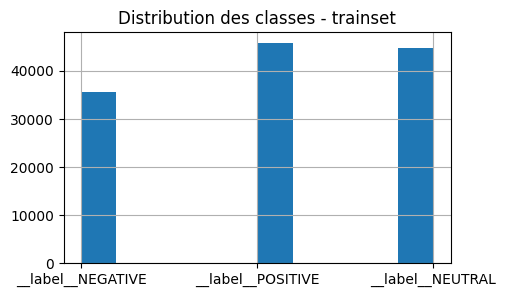

In [29]:
count_pos = df_train["Sentiment"].value_counts()["__label__POSITIVE"]
count_neu = df_train["Sentiment"].value_counts()["__label__NEUTRAL"]
count_neg = df_train["Sentiment"].value_counts()["__label__NEGATIVE"]

ratio_neu = (count_pos-count_neu) // count_neu
ratio_neg = (count_pos-count_neg) // count_neg

mask = (df_train["Sentiment"]=="__label__NEUTRAL")
items = [df_train]+[df_train[mask]]*ratio_neu
df_train = pd.concat(items,ignore_index=True)

mask = (df_train["Sentiment"]=="__label__NEGATIVE")
items = [df_train]+[df_train[mask]*ratio_neg]
df_train = pd.concat(items,ignore_index=True)

fig = plt.figure(figsize=(5,3))
df_train["Sentiment"].hist()
plt.title("Distribution des classes - trainset")


# Training

In [58]:
LABELS = [0, 2]

def plotCMX(labels, cm):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    ax.set_xticklabels([""]+labels)
    plt.ylabel('Actuals', fontsize=18)
    ax.set_yticklabels([""]+labels)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

## 2 classes

In [50]:
# Create features
vectorizer = CountVectorizer(max_features=2000, stop_words=stopwords.words('french'))
X_train_bin = vectorizer.fit_transform(df_train_bin["text_preprocess"].values)
y_train_bin = df_train_bin["Sentiment"].values

X_test_bin = vectorizer.transform(df_test_bin["text_preprocess"].values)
y_test_bin = df_test_bin["Sentiment"].values

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:10]})

Vocabulary size:  2000
{'bonjour': 265, 'passer': 1316, 'premier': 1400, 'commande': 399, 'décembre': 617, 'moyen': 1198, 'paiement': 1289, 'virement': 1923, 'fournir': 835, 'avis': 211}


In [55]:
rf = RandomForestClassifier(n_jobs=-1)

# Entraînement du modèle.
rf.fit(X_train_bin, y_train_bin)

RandomForestClassifier(n_jobs=-1)

### Evaluation

/data/DATALAB_PAU/18_HPC/tmp/ipykernel_75949/2176178015.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+labels)
/data/DATALAB_PAU/18_HPC/tmp/ipykernel_75949/2176178015.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+labels)


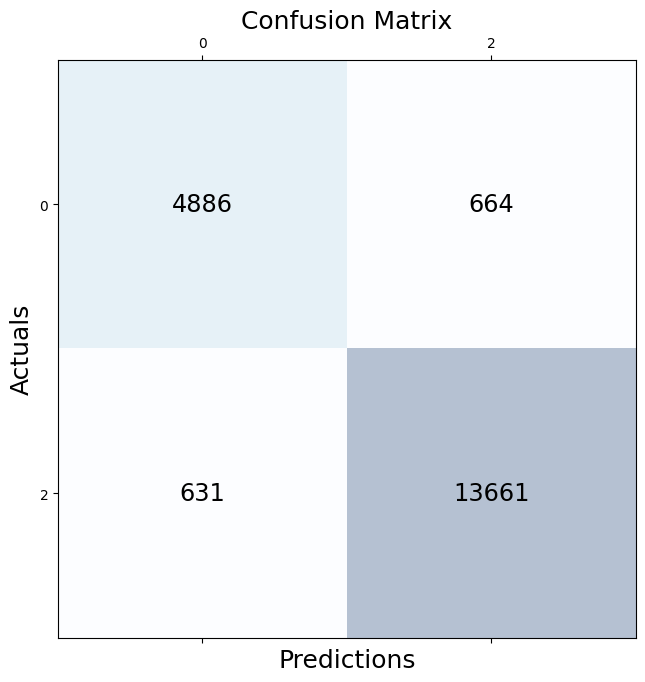

In [59]:
y_pred_bin = rf.predict(X_test_bin)

cm = confusion_matrix(y_test_bin, y_pred_bin)
plotCMX(LABELS, cm)

In [60]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5550
           2       0.95      0.96      0.95     14292

    accuracy                           0.93     19842
   macro avg       0.92      0.92      0.92     19842
weighted avg       0.93      0.93      0.93     19842



## 3 classes

In [61]:
# Create features
vectorizer = CountVectorizer(max_features=2000, stop_words=stopwords.words('french'))
X_train = vectorizer.fit_transform(df_train["text_preprocess"].values)
y_train = df_train["Sentiment"].values

X_test = vectorizer.transform(df_test["text_preprocess"].values)
y_test = df_test["Sentiment"].values

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:10]})

Vocabulary size:  2000
{'acheter': 89, 'dernièrement': 546, 'machine': 1096, 'laver': 1051, 'site': 1718, 'promesse': 1441, 'cdiscount': 330, 'livreur': 1074, 'reprendre': 1588, 'ancien': 136}


In [62]:
rf = RandomForestClassifier(n_jobs=-1)

# Entraînement du modèle.
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

### Evaluation

/data/DATALAB_PAU/18_HPC/tmp/ipykernel_75949/2176178015.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+labels)
/data/DATALAB_PAU/18_HPC/tmp/ipykernel_75949/2176178015.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+labels)


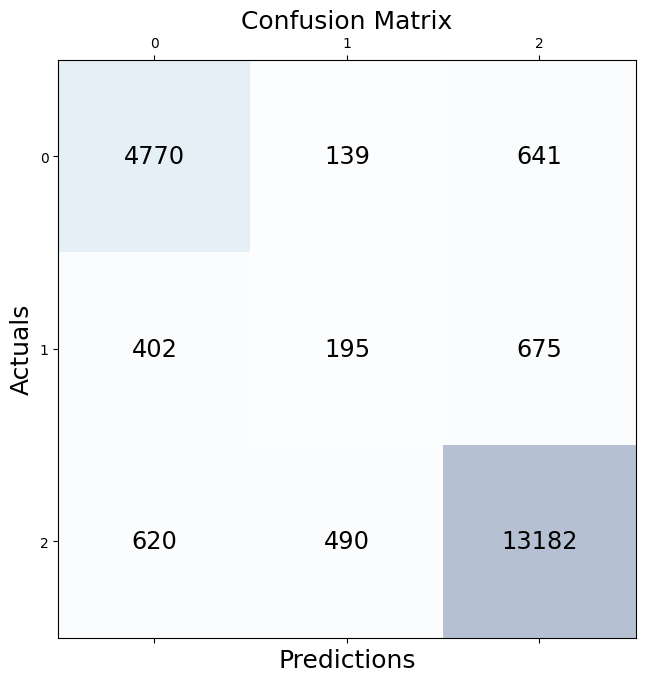

In [63]:
LABELS = [0, 1, 2]
y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plotCMX(LABELS, cm)

In [64]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

__label__NEGATIVE       0.82      0.86      0.84      5550
 __label__NEUTRAL       0.24      0.15      0.19      1272
__label__POSITIVE       0.91      0.92      0.92     14292

         accuracy                           0.86     21114
        macro avg       0.66      0.65      0.65     21114
     weighted avg       0.85      0.86      0.85     21114



# TF-IDF

## 2 classes

In [71]:
# Application de TF-IDF aux avis
vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('french'), ngram_range=(2,4))
X_train_bin_tfidf = vectorizer.fit_transform(df_train_bin["text_preprocess"].values)
X_test_bin_tfidf = vectorizer.transform(df_test_bin["text_preprocess"].values)

rf = RandomForestClassifier(n_jobs=-1)

# Entraînement du modèle.
rf.fit(X_train_bin_tfidf, y_train_bin)

RandomForestClassifier(n_jobs=-1)

/data/DATALAB_PAU/18_HPC/tmp/ipykernel_75949/2176178015.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+labels)
/data/DATALAB_PAU/18_HPC/tmp/ipykernel_75949/2176178015.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+labels)


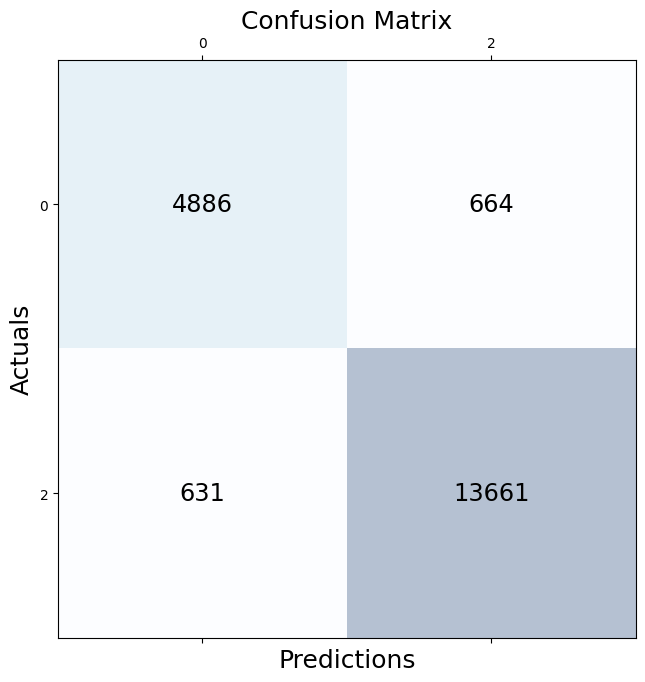

In [72]:
LABELS = [0, 2]
y_pred = rf.predict(X_test_bin_tfidf)

cm = confusion_matrix(y_test_bin, y_pred_bin)
plotCMX(LABELS, cm)

In [73]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5550
           2       0.95      0.96      0.95     14292

    accuracy                           0.93     19842
   macro avg       0.92      0.92      0.92     19842
weighted avg       0.93      0.93      0.93     19842



### Explicability

In [76]:


explainer = shap.TreeExplainer(rf, data=X_test_bin_tfidf.toarray())

shap_values = explainer.shap_values(X_test_bin_tfidf.todense(), approximate=True)

print('Expected Value:', explainer.expected_value)

pd.DataFrame(shap_values).head()

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## 3 classes

In [67]:
# Application de TF-IDF aux avis
vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('french'), ngram_range=(2,4))
X_train_tfidf = vectorizer.fit_transform(df_train["text_preprocess"].values)
X_test_tfidf = vectorizer.transform(df_test["text_preprocess"].values)

rf = RandomForestClassifier(n_jobs=-1)

# Entraînement du modèle.
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(n_jobs=-1)

/data/DATALAB_PAU/18_HPC/tmp/ipykernel_75949/2176178015.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+labels)
/data/DATALAB_PAU/18_HPC/tmp/ipykernel_75949/2176178015.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+labels)


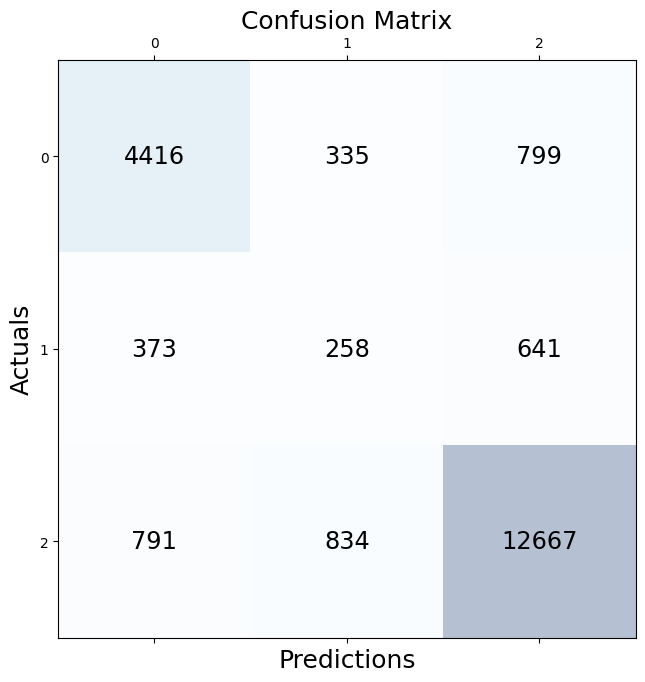

In [69]:
LABELS = [0, 1, 2]
y_pred = rf.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
plotCMX(LABELS, cm)

In [70]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

__label__NEGATIVE       0.79      0.80      0.79      5550
 __label__NEUTRAL       0.18      0.20      0.19      1272
__label__POSITIVE       0.90      0.89      0.89     14292

         accuracy                           0.82     21114
        macro avg       0.62      0.63      0.63     21114
     weighted avg       0.83      0.82      0.82     21114

